In [349]:
import pandas as pd
import matplotlib.pyplot as mltp
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import sklearn as sk
import seaborn as sea
import re 
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

Laden der Inhalte aus den vorbereiteten Daten rein, welche basierend auf de Wortanzahl aber auch Sätzen selektiert wurden

In [350]:
def stripping(liste):
    return [i.strip() for i in liste]

In [351]:
df=pd.read_csv('data/train_500.csv',converters={'sent_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize': lambda x: x[1:-1].strip('][').replace("'","").strip().split(','),
'word_tokenize_without_stopwords': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'word_tokenize_without_stopwords_port': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
,'msg_lemmatized': lambda x: x[1:-1].strip('][').replace("'","").strip().split(',')
})

df['word_tokenize']=df['word_tokenize'].progress_apply(stripping)
df['sent_tokenize']=df['sent_tokenize'].progress_apply(stripping)
df['word_tokenize_without_stopwords']=df['word_tokenize_without_stopwords'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)
df['word_tokenize_without_stopwords_port']=df['word_tokenize_without_stopwords_port'].progress_apply(stripping)

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

  0%|          | 0/19500 [00:00<?, ?it/s]

In [352]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df=df.reset_index(drop=True)

In [353]:
print(f'Rows in the df: {len(df.index)}')

Rows in the df: 19500


In [354]:
df.head()

,id,date,text,lang,language_2,word_tokenize,sent_tokenize,count_word,count_sent,word_tokenize_num_of_stopwords,word_tokenize_without_stopwords,word_tokenize_without_stopwords_port,msg_lemmatized,cleanLinks,word_per_sent_mean,gender,age,topic,sign
0,2970791,"25,May,2004",This blog is being posted due to the fact that...,en,en,"[This, blog, is, being, posted, due, to, the, ...",[This blog is being posted due to the fact tha...,83,4,34,"[This, blog, posted, due, fact, little, develo...","[thi, blog, post, due, fact, littl, develop, h...","[thi, blog, post, due, fact, littl, deve...",This blog is being posted due to the fact that...,20.75,male,14,Student,Sagittarius
1,3931851,"02,agosto,2004",So I have a big fucking interview tomorrow for...,en,en,"[So, I, have, a, big, fucking, interview, tomo...",[So I have a big fucking interview tomorrow fo...,88,5,31,"[So, I, big, fucking, interview, tomorrow, new...","[so, i, big, fuck, interview, tomorrow, new, s...","[so, i, big, fuck, interview, tomorrow, ...",So I have a big fucking interview tomorrow for...,17.60,male,15,Student,Pisces
2,3481650,"07,July,2004",I was reminded just now of the time Ashley and...,en,en,"[I, was, reminded, just, now, of, the, time, A...",[I was reminded just now of the time Ashley an...,574,32,234,"[I, reminded, time, Ashley, I, drove, Kemah, w...","[i, remind, time, ashley, i, drove, kemah, win...","[i, remind, time, ashley, i, drove, kema...",I was reminded just now of the time Ashley and...,17.94,female,17,Student,Gemini
3,4187211,"20,August,2004",I was checking up on my cousin Dylan and Fanni...,en,en,"[I, was, checking, up, on, my, cousin, Dylan, ...","[""I was checking up on my cousin Dylan and Fan...",84,3,32,"[I, checking, cousin, Dylan, Fannie, ""s"", wedd...","[i, check, cousin, dylan, fanni, ""s"", wed, sit...","[i, check, cousin, dylan, fanni, ""s"", we...",I was checking up on my cousin Dylan and Fanni...,28.00,female,23,Student,Taurus
4,3686696,"24,June,2004",for the NME interview click urlLink part 1 and...,en,en,"[for, the, NME, interview, click, urlLink, par...",[for the NME interview click urlLink part 1 an...,12,1,3,"[NME, interview, click, urlLink, part, 1, urlL...","[nme, interview, click, urllink, part, 1, urll...","[nme, interview, click, urllink, part, 1,...",for the NME interview click urlLink part 1 and...,12.00,female,23,Student,Aquarius


In [355]:
import random
import string
import nltk
from nltk import ngrams as get_ngrams


start_of_seq_token = "<START>"


class NgramModel(object):
    def __init__(self, n):
        self.n = n

        # dictionary that keeps list of candidate words given context
        self.context = {}
        self.ngram_counter_without_pre = {}

        # keeps track of how many times ngram has appeared in the text before
        self.ngram_counter = {}
        self.unique_count={}
        self.listen_append=[]


    def update(self, sentence: str,liste:list):
        """
        Updates the language model with an additional sentence (string)
        :param sentence: input text
        """
        liste=liste
        n = self.n
        sentence = (n-1) * [start_of_seq_token] + [w for w in nltk.word_tokenize(sentence) if w not in string.punctuation]
        ngrams = get_ngrams(sentence, n)
        for ngram in ngrams:
            #print(ngram)
            prev_words, target_word = ngram[:-1], ngram[-1]
            if (prev_words, target_word) in self.ngram_counter:
                self.ngram_counter[(prev_words, target_word)] += 1.0
            else:
                self.ngram_counter[(prev_words, target_word)] = 1.0


            if target_word in self.unique_count and target_word not in liste:
                liste.append(target_word)
                self.unique_count[target_word] += 1.0
                #print(1)

            elif target_word in self.unique_count and target_word  in liste:
                #print(2)
                pass
                
            else:
                #print(3)
                self.unique_count[target_word] = 1.0

            if target_word in self.ngram_counter_without_pre:
                
                self.ngram_counter_without_pre[target_word] += 1.0
            else:
                self.ngram_counter_without_pre[target_word] = 1.0

            if prev_words in self.context:
                if target_word not in self.context[prev_words]:
                    self.context[prev_words].append(target_word)
                else:
                    pass
            else:
                self.context[prev_words] = [target_word]
        return liste

    
    def prob(self, context, token):
        """
        Calculates probability of a candidate token to be generated given a context
        :return: conditional probability
        """
        try:
            count_of_token = self.ngram_counter[(context, token)]
            count_of_context = float(len(self.context[context]))
            result = count_of_token / count_of_context

        except KeyError:
            result = 0.0
            
        return result
    
    def random_token(self, context):
        """
        Given a context, selects the next word to append in a sequence
        :param context:
        :return:
        """
        r = random.random() / 50
        map_to_probs = {}
        token_of_interest = self.context[context]
        for token in token_of_interest:
            map_to_probs[token] = self.prob(context, token)

        summ = 0
        for token in sorted(map_to_probs):
            summ += map_to_probs[token]
            if summ > r:
                return token
        
        return next(sorted(map_to_probs))

    def generate_text(self, token_count: int):
        """
        :param token_count: number of words to be produced
        :return: generated text
        """
        n = self.n
        context_queue = (n - 1) * [start_of_seq_token]
        result = []
        for _ in range(token_count):
            obj = self.random_token(tuple(context_queue))
            result.append(obj)
            if n > 1:
                context_queue.pop(0)
                if obj == '.':
                    context_queue = (n - 1) * [start_of_seq_token]
                else:
                    context_queue.append(obj)
        return ' '.join(result)

In [356]:
model = NgramModel(n=2)
for x in tqdm(range(len(df.index))):
#for x in tqdm(range(3)):  
    sentences = [sent for sent in nltk.sent_tokenize(df['text'][x]) if sent]
    
    liste=[]
    for sent in sentences:
        #num=1
        #print(sent)
        liste=model.update(sent,liste)
        #liste=model.clac(sent,liste)
    #print(liste)

    
print(len(model.unique_count))

  0%|          | 0/19500 [00:00<?, ?it/s]

121338


Die Texte werden basierend auf ihren Inhalten analysiert, wobei die Wortanazahl gesamt, sowie des Auftretens der unterschiedlichen Texte Analysiert wird.

In [357]:
words_in_texts=pd.DataFrame(model.ngram_counter_without_pre,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
words_in_texts.head()

,word,num
0,This,3141.0
1,blog,2000.0
2,is,33051.0
3,being,2866.0
4,posted,339.0


In [358]:
words_in_texts=words_in_texts.loc[:, ~words_in_texts.columns.str.contains('^Unnamed')]
words_in_texts.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [359]:
count_overview=pd.DataFrame(model.unique_count,index=[0]).transpose().reset_index().rename(columns={'index':'word',0:'num'})
count_overview.to_csv('data/count_overview.csv')

In [360]:
count_overview=pd.read_csv('data/count_overview.csv')
count_overview=count_overview.loc[:, ~count_overview.columns.str.contains('^Unnamed')]
count_overview.sort_values(by= 'num',ascending=False).head()

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0


In [361]:
count_overview.sort_values(by= 'num',ascending=False).head(20)

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [362]:
count_ordnung=count_overview.sort_values(by= 'num',ascending=False)

In [363]:
words_that_are_often=count_ordnung[count_ordnung['num']>6000]
words_that_are_often

,word,num
7,the,15931.0
6,to,15476.0
29,a,14476.0
51,and,14383.0
18,of,13460.0
41,I,13141.0
79,in,12230.0
146,it,11858.0
2,is,11817.0
9,that,11724.0


In [364]:
words_in_texts=words_in_texts.sort_values(by= 'num',ascending=False)
words_in_texts.head()

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0


In [365]:
words_in_texts[words_in_texts['num']>7000]

,word,num
7,the,108773.0
41,I,100310.0
6,to,88167.0
51,and,72508.0
29,a,63895.0
...,...,...
72,know,7559.0
43,if,7316.0
181,by,7199.0
327,would,7052.0


In [366]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [367]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(df.text.tolist()):
    doc = nlp(text)
    text_list_word=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #print(text_list)
d = {'text':df.text.tolist(),'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list,'gender':df.gender.tolist(),'sign':df.sign.tolist(),'topic':df.topic.tolist()}
df_text_spacy=pd.DataFrame(data=d)
    


  0%|          | 0/19500 [00:00<?, ?it/s]

In [368]:
df_text_spacy.head()

,text,text_list,lemma_list,pos_list,tag_list,dep_list,shape_list,alpha_list,stop_list,gender,sign,topic
0,This blog is being posted due to the fact that...,"[This, blog, is, being, posted, due, to, the, ...","[this, blog, be, be, post, due, to, the, fact,...","[DET, NOUN, AUX, AUX, VERB, ADP, ADP, DET, NOU...","[DT, NN, VBZ, VBG, VBN, IN, IN, DT, NN, IN, JJ...","[det, nsubjpass, aux, auxpass, ROOT, prep, pco...","[Xxxx, xxxx, xx, xxxx, xxxx, xxx, xx, xxx, xxx...","[True, True, True, True, True, True, True, Tru...","[True, False, True, True, False, True, True, T...",male,Sagittarius,Student
1,So I have a big fucking interview tomorrow for...,"[So, I, have, a, big, fucking, interview, tomo...","[so, I, have, a, big, fucking, interview, tomo...","[ADV, PRON, VERB, DET, ADJ, ADJ, NOUN, NOUN, A...","[RB, PRP, VBP, DT, JJ, JJ, NN, NN, IN, PRP$, J...","[advmod, nsubj, ROOT, det, amod, amod, dobj, n...","[Xx, X, xxxx, x, xxx, xxxx, xxxx, xxxx, xxx, x...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, False, False, False, ...",male,Pisces,Student
2,I was reminded just now of the time Ashley and...,"[I, was, reminded, just, now, of, the, time, A...","[I, be, remind, just, now, of, the, time, Ashl...","[PRON, AUX, VERB, ADV, ADV, ADP, DET, NOUN, PR...","[PRP, VBD, VBN, RB, RB, IN, DT, NN, NNP, CC, P...","[nsubjpass, auxpass, ROOT, advmod, advmod, pre...","[X, xxx, xxxx, xxxx, xxx, xx, xxx, xxxx, Xxxxx...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, True, Fa...",female,Gemini,Student
3,I was checking up on my cousin Dylan and Fanni...,"[I, was, checking, up, on, my, cousin, Dylan, ...","[I, be, check, up, on, my, cousin, Dylan, and,...","[PRON, AUX, VERB, ADP, ADP, PRON, NOUN, PROPN,...","[PRP, VBD, VBG, RP, IN, PRP$, NN, NNP, CC, NNP...","[nsubj, aux, ROOT, prt, prep, poss, pobj, poss...","[X, xxx, xxxx, xx, xx, xx, xxxx, Xxxxx, xxx, X...","[True, True, True, True, True, True, True, Tru...","[True, True, False, True, True, True, False, F...",female,Taurus,Student
4,for the NME interview click urlLink part 1 and...,"[for, the, NME, interview, click, urlLink, par...","[for, the, NME, interview, click, urllink, par...","[SCONJ, DET, PROPN, NOUN, VERB, NOUN, NOUN, NU...","[IN, DT, NNP, NN, VB, NN, NN, CD, CC, VB, NN, CD]","[mark, det, compound, nsubj, ROOT, dobj, dobj,...","[xxx, xxx, XXX, xxxx, xxxx, xxxXxxx, xxxx, d, ...","[True, True, True, True, True, True, True, Fal...","[True, True, False, False, False, False, True,...",female,Aquarius,Student


In [369]:
from nltk.corpus import stopwords
def stopwords_count_and_removal(data, col, language="english"):

    stoplist = stopwords.words(language)

    number_of_stopwords = []
    text_without_stopwords = []

    col_name_number_of_stopwords = col + "_num_of_stopwords"
    col_name_without_stopwords = col + "_without_stopwords"

    for i in tqdm(range(len(data))):
        no_of_words = 0
        without_stopwords = []
        for word in data[col][i]:
            if word in stoplist:
                no_of_words += 1
            else:
                without_stopwords.append(word)
        
        text_without_stopwords.append(without_stopwords)
        number_of_stopwords.append(no_of_words)

    data[col_name_number_of_stopwords] = number_of_stopwords
    data[col_name_without_stopwords] = text_without_stopwords


    return data

In [370]:
df_text_spacy=stopwords_count_and_removal(df_text_spacy,'lemma_list')

  0%|          | 0/19500 [00:00<?, ?it/s]

# LDA

In [472]:
import numpy as np
import json
import glob

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import pickle 

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [473]:
stopwords = stopwords.words('english')

In [474]:
text_liste=df_text_spacy.text.tolist()
text_liste[0][0:90]

'This blog is being posted due to the fact that little development has happened recently re'

SpaCy ist eine beliebte Open-Source-Bibliothek für die Verarbeitung natürlicher Sprache (NLP) in Python. Sie enthält unter anderem Werkzeuge für Tokenisierung, Part-of-Speech-Tagging, Dependency Parsing und Named Entity Recognition. Diese Werkzeuge sind in einer Pipeline organisiert, die den Eingabetext verarbeitet und eine Vielzahl von linguistischen Merkmalen extrahiert, die für eine Vielzahl von NLP-Aufgaben verwendet werden können.

Der erste Schritt in der SpaCy-Pipeline ist die Tokenisierung, d. h. die Zerlegung des Eingabetextes in einzelne Wörter (Token). Dies geschieht anhand einer Reihe von Regeln, die Interpunktion, Kontraktionen und andere Sonderfälle berücksichtigen. Die so entstandenen Token werden dann mit verschiedenen linguistischen Merkmalen versehen, z. B. mit ihrem Part-of-Speech-Tag und ihrem Lemma (Grundform).

Der nächste Schritt in der Pipeline ist das Part-of-Speech-Tagging, bei dem jedes Token mit seinem Part of Speech (z. B. Substantiv, Verb oder Adjektiv) gekennzeichnet wird. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Part-of-Speech-Tagging ist ein wichtiger Schritt, da es dem Modell ermöglicht, die grammatikalische Rolle jedes Wortes im Satz zu identifizieren, was für Aufgaben wie Dependency Parsing und Named Entity Recognition nützlich sein kann.

Beim Dependency Parsing werden die Beziehungen zwischen Wörtern in einem Satz identifiziert, z. B. Subjekt-Verben-Beziehungen und Modifikator-Kopf-Beziehungen. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen annotierten Textkorpus trainiert wurde. Das Parsen von Abhängigkeiten ist ein wichtiger Schritt, da es dem Modell ermöglicht, die Struktur des Satzes und die Beziehungen zwischen den Wörtern zu verstehen, was für Aufgaben wie die Informationsextraktion und die maschinelle Übersetzung nützlich sein kann. Jedoch wird dies Aufgrund der Anwendung ncith verwendet, da dies meist mit den höchsten Aufwand erzeugt

Bei der Erkennung benannter Entitäten handelt es sich um den Prozess der Identifizierung und Klassifizierung benannter Entitäten in Texten, z. B. Personen, Organisationen und Orte. Dies geschieht in der Regel mithilfe eines maschinellen Lernmodells, das auf einem großen kommentierten Textkorpus trainiert wurde. Die Erkennung von benannten Entitäten ist ein wichtiger Schritt, da sie es dem Modell ermöglicht, strukturierte Informationen aus unstrukturiertem Text zu extrahieren, was für Aufgaben wie die Informationsextraktion und die Textklassifizierung nützlich sein kann.

Insgesamt ist die SpaCy-Pipeline ein leistungsfähiges Werkzeug zur Extraktion einer Vielzahl von linguistischen Merkmalen aus Text, die für eine Vielzahl von NLP-Aufgaben verwendet werden können. Durch die Kombination dieser Merkmale mit Modellen des maschinellen Lernens ist es möglich, anspruchsvolle NLP-Anwendungen zu erstellen, die natürlichsprachliche Texte analysieren und verstehen können.


In [475]:
def lemmatization_test(texts,  allowed_posttags=['NOUN','ADJ','VERB','ADV']):
    nlp=spacy.load('en_core_web_md',disable=['parser','ner'])
    texts_out=[]
    for text in tqdm(texts):
        doc= nlp(text)
        new_text=[]
        for token in doc:
            if token.pos_ in allowed_posttags:
                new_text.append(token.lemma_)
        final=' '.join(new_text)
        texts_out.append(final)
    return texts_out

In [476]:
lemma_text=lemmatization_test(text_liste)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [477]:
print(lemma_text[0][0:90])

blog post fact little development happen recently regard last day school uniform swap plan


In [478]:
def gen_words(texts):
    final=[]
    for text in tqdm(texts):
        new= gensim.utils.simple_preprocess(text,deacc=True)
        final.append(new)
    return final

In [479]:
data_words=gen_words(lemma_text)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [480]:
print(data_words[0][0:90])

['blog', 'post', 'fact', 'little', 'development', 'happen', 'recently', 'regard', 'last', 'day', 'school', 'uniform', 'swap', 'plan', 'switch', 'uniform', 'certain', 'individual', 'somehow', 'organize', 'soon', 'also', 'consider', 'last', 'day', 'school', 'think', 'participate', 'success', 'plan', 'soon', 'pray', 'drop', 'dress', 'code', 'day', 'last', 'day', 'school']


### Bigrams and Trigrams

Ein n-Gramm ist eine zusammenhängende Sequenz von n Elementen aus einer bestimmten Text- oder Sprachprobe. N-Gramme sind in der natürlichen Sprachverarbeitung und Computerlinguistik weit verbreitet. Sie können für eine Vielzahl von Aufgaben verwendet werden, z. B. für die Sprachmodellierung, die Informationsbeschaffung und die maschinelle Übersetzung.

Bigramme sind Zwei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Bigramme zum Beispiel "die Katze", "Katze in" und "in der". Bigramme können für Aufgaben wie Rechtschreibkorrektur, Sprachmodellierung und Informationsabfrage nützlich sein.

Trigramme sind Drei-Wort-Folgen von Wörtern, die nacheinander in einem Text vorkommen. In dem Satz "die Katze im Hut" wären die Trigramme zum Beispiel "die Katze in", "die Katze im" und "im Hut". Trigramme können für Aufgaben wie Sprachmodellierung und Informationsabfrage nützlich sein.

N-Gramme werden häufig in der natürlichen Sprachverarbeitung verwendet, da sie den Kontext und die Bedeutung von Wörtern in einem Text erfassen können. Beispielsweise ist das Bigramm "New York" informativer als die einzelnen Wörter "New" und "York", da es darauf hindeutet, dass die beiden Wörter miteinander verwandt sind und sich wahrscheinlich auf die Stadt beziehen. In ähnlicher Weise ist das Trigramm "die Katze in" informativer als die Bigramme "die Katze" und "Katze in", da es darauf hindeutet, dass die Wörter Teil einer Sequenz sind und wahrscheinlich in irgendeiner Weise miteinander in Beziehung stehen.

Insgesamt können n-Gramme ein nützliches Werkzeug für das Verständnis und die Verarbeitung von Sprachdaten sein, und Bigramme und Trigramme werden häufig in einer Vielzahl von Aufgaben der natürlichen Sprachverarbeitung verwendet.


In [481]:
bigram_phrases=gensim.models.Phrases(data_words,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words)
data_bigrams_trigrams=make_trgram(data_bigrams)

In [482]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

Ein wichtiger aber auch schwieriger Aspekt des LDA prozesses ist die Bestimmung der ANzhal der Topics. Hierbei ist wie bei Maschine Learning eine autonmatische Verbesserung und Lernen nicht gegeben, weshlab durch erforschen und Analysen die Optimalen Parameter gefunden werden müssen. Dies ist besonders schweirig, da meist Klassen entstehen, welche eine hohe Anzahl an Elementen enthalten

In [483]:
num_topics=38

In [484]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [485]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.9840000000000005, 1: 0.9060000000000002, 2: 0.8200000000000005, 3: 0.6530000000000001, 4: 0.8790000000000002, 5: 0.9000000000000002, 6: 0.854, 7: 0.7980000000000003, 8: 0.7630000000000002, 9: 0.7370000000000001, 10: 0.6970000000000001, 11: 0.9150000000000004, 12: 0.8930000000000003, 13: 0.9440000000000006, 14: 0.7490000000000002, 15: 0.8400000000000002, 16: 0.9880000000000003, 17: 0.6190000000000001, 18: 0.8820000000000003, 19: 0.8620000000000003, 20: 0.9650000000000003, 21: 0.795, 22: 0.83, 23: 0.7520000000000002, 24: 0.9140000000000005, 25: 0.8910000000000001, 26: 0.8100000000000003, 27: 0.9710000000000004, 28: 0.8570000000000003, 29: 0.8440000000000004, 30: 0.8500000000000003, 31: 0.9080000000000001, 32: 0.9320000000000006, 33: 0.8750000000000003, 34: 0.8930000000000002, 35: 0.7950000000000002, 36: 0.7820000000000003, 37: 0.8080000000000002}


Zur bestimmung der optimalen Anzahl von relevanten Wörtern wurden daher auf 100 gestzt, um nah an 100% zu sein. Da je nach Wort eine untershciedliche Wahrscheinlichkeit und Somit gewichtung für das eine oder andere Topic entsteht

Daher werden die Wörter im nahchinein genutzt, um eine zurodnung durch abgleich und multiplikation der Gewichtung zu erziehlen, um basierend davon jenes Topic zu deklarieren, welches am Wahrscheinlichsten ist. Aus diesem Grund dies aus dem Wert der Summe der auftretenden Werte verglichen mit der Summe der Unterschiedlichen Gewichte mäglicher alternastiven Topics
Dafür wird volgendes getan:
1. Identifizieren, welche Wörter eines Topics und wei oft in einem Text enthalten sind
2. Basierend auf diesen die Wahrscheinlihckeiten bestimmen
3. Diese Addieren und den höchsten Wert identifizieren, welche das Wahrschienlichste Topic entspricht


In [486]:
df_topic=pd.DataFrame(data=dic)
df_topic.head()

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,33_word,33_per,34_word,34_per,35_word,35_per,36_word,36_per,37_word,37_per
0,go,0.176,world,0.123,time,0.023,weird,0.194,free,0.104,...,learn,0.099,nbsp,0.494,note,0.122,add,0.224,link,0.120
1,then,0.069,believe,0.103,good,0.021,brother,0.137,study,0.059,...,however,0.096,comment,0.073,view,0.112,create,0.110,hair,0.077
2,there,0.040,student,0.050,day,0.021,st,0.080,sign,0.058,...,question,0.087,box,0.042,step,0.092,character,0.097,church,0.068
3,guy,0.035,lie,0.044,now,0.020,stare,0.072,level,0.047,...,apparently,0.056,smart,0.032,build,0.065,window,0.064,ill,0.063
4,home,0.034,chance,0.043,really,0.019,universe,0.050,floor,0.042,...,result,0.040,accept,0.030,interested,0.060,difference,0.054,click,0.040


In [487]:
def create_df_overview(data_words,num_topics,df_topic):
    topic_of_text=[]
    for text in tqdm(data_words):
        liste_text_top=[]
        for t in range(num_topics):
            liste_top=[]
            for element in df_topic[f'{t}_word'].tolist():
                liste_top.append(len([i for i, e in enumerate(text) if e == element]))
    
            Result = []
            for i1, i2 in zip(liste_top, df_topic[f'{t}_per'].tolist()):
                Result.append(i1*i2)
            liste_text_top.append(sum(Result))    
        if sum(liste_text_top)!=0:
            topic_of_text.append([max(range(len(liste_text_top)), key=liste_text_top.__getitem__),max(liste_text_top)/sum(liste_text_top),liste_text_top])
        else:
            topic_of_text.append(['None','None',liste_text_top])
    return pd.DataFrame(data=topic_of_text,columns=['topic_num','percent','perc_list'])
       


In [488]:
pd.DataFrame(data=dic).to_csv('LDA/lda_gesamt.csv')

In [489]:
overview=pd.merge(df[['text','topic','gender','age']], create_df_overview(data_words,num_topics,df_topic), left_index=True, right_index=True)
overview.head()

  0%|          | 0/19500 [00:00<?, ?it/s]

,text,topic,gender,age,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,male,14,7,0.441402,"[0.0, 0.0, 0.16700000000000004, 0.0, 0.021, 0...."
1,So I have a big fucking interview tomorrow for...,Student,male,15,20,0.312445,"[0.176, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,I was reminded just now of the time Ashley and...,Student,female,17,27,0.203974,"[1.863999999999999, 0.05, 0.5950000000000003, ..."
3,I was checking up on my cousin Dylan and Fanni...,Student,female,23,20,0.278658,"[0.0, 0.0, 0.08300000000000002, 0.08, 0.0, 0.0..."
4,for the NME interview click urlLink part 1 and...,Student,female,23,31,0.946866,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


- ml --> prediction welches richtige topic man hat --> meist mehr topics --> ggf noch pca --> (downstream task) --> klassifikation
- einrichtigen text --> grundlagen teil und praxis teil 

In [490]:
# Build App
import socket
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output

In [491]:

def vis_topic(overview):
    sock = socket.socket()
    sock.bind(('', 0))
    sock.getsockname()[1]
    app = JupyterDash(__name__)
    app.layout = html.Div([
        html.H1("Übersicht der Verteilungen basierend auf den initialen Topics"),
        dcc.Graph(id='graph'),
        html.Label([
            "Topics",
            dcc.Dropdown(
                id='colorscale-dropdown', clearable=False,
                value='plasma', options=[
                    {'label': c, 'value': c}
                    for c in overview['topic'].unique().tolist()
                ]
                )
        ]),
    ])
    # Define callback to update graph
    @app.callback(
        Output('graph', 'figure'),
        [Input("colorscale-dropdown", "value")]
    )
    def update_figure(colorscale):
        testdf = overview[overview['topic']==colorscale].topic_num.value_counts().rename_axis('unique_values').reset_index(name='counts')
        return px.pie(testdf, values='counts', names='unique_values')
    # Run app and display result inline in the notebook
    app.run_server(mode='inline', port=sock.getsockname()[1])


In [492]:
def vis_topic_num(overview):
    sock = socket.socket()
    sock.bind(('', 0))
    sock.getsockname()[1]
    app = JupyterDash(__name__)
    app.layout = html.Div([
        html.H1("Übersicht der Verteilungen basierend auf den initialen Topics"),
        dcc.Graph(id='graph'),
        html.Label([
            "Topics",
            dcc.Dropdown(
                id='colorscale-dropdown', clearable=False,
                value='plasma', options=[
                    {'label': c, 'value': c}
                    for c in overview['topic_num'].unique().tolist()
                ]
                )
        ]),
    ])
    # Define callback to update graph
    @app.callback(
        Output('graph', 'figure'),
        [Input("colorscale-dropdown", "value")]
    )
    def update_figure(colorscale):
        testdf = overview[overview['topic_num']==colorscale].topic.value_counts().rename_axis('topic').reset_index(name='counts')
        return px.pie(testdf, values='counts', names='topic')
    # Run app and display result inline in the notebook
    app.run_server(mode='inline', port=sock.getsockname()[1])

In [493]:
vis_topic(overview)

In [494]:
vis_topic_num(overview)

In [495]:
overview[overview.topic=='Student'].topic_num.value_counts()

20      116
27       78
31       68
25       43
0        34
22       24
7        21
15       18
16       18
19       12
34       11
6         8
2         7
11        5
21        5
None      4
9         3
36        3
24        3
28        2
18        2
1         2
23        2
10        2
4         2
29        1
13        1
8         1
30        1
12        1
14        1
37        1
Name: topic_num, dtype: int64

In [496]:
tes=['a','b','c','d']
[i for i, e in enumerate([1, 2, 1]) if e == 0]

[]

In [497]:
len([i for i, e in enumerate([1, 2, 1]) if e == 0])

0

In [498]:
for idx, topic in lda_model.print_topics(num_topics,num_words=30):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.176*"go" + 0.069*"then" + 0.040*"there" + 0.035*"guy" + 0.034*"home" + 0.027*"fun" + 0.025*"night" + 0.024*"watch" + 0.023*"eat" + 0.023*"morning" + 0.022*"cool" + 0.021*"weekend" + 0.019*"buy" + 0.019*"house" + 0.018*"walk" + 0.017*"sit" + 0.015*"pretty" + 0.015*"last_night" + 0.013*"meet" + 0.013*"around" + 0.012*"later" + 0.012*"together" + 0.012*"able" + 0.012*"yesterday" + 0.011*"drink" + 0.011*"less" + 0.011*"decide" + 0.011*"early" + 0.010*"hang" + 0.010*"food"
Topic: 1 
Words: 0.123*"world" + 0.103*"believe" + 0.050*"student" + 0.044*"lie" + 0.043*"chance" + 0.039*"lead" + 0.036*"event" + 0.033*"possible" + 0.030*"present" + 0.027*"war" + 0.023*"everyday" + 0.022*"afraid" + 0.022*"human" + 0.022*"discover" + 0.020*"exist" + 0.019*"field" + 0.019*"near" + 0.017*"respect" + 0.017*"decision" + 0.017*"express" + 0.015*"grant" + 0.014*"easily" + 0.014*"gain" + 0.013*"daily" + 0.013*"freedom" + 0.012*"button" + 0.009*"emotion" + 0.009*"holy" + 0.008*"announce" + 0.

## Visualisation

In [499]:

import pyLDAvis.gensim_models as gensimvis
import pickle 
pyLDAvis.enable_notebook()
import os
LDAvis_data_filepath = os.path.join('pic/test_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word,mds='mmds',R=30)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'pic/test_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.445533 -0.325863       1        1  34.062996
24    -0.288047 -0.456993       2        1  11.447595
16    -0.503005 -0.166446       3        1   9.648540
0     -0.547209  0.031448       4        1   8.959859
27    -0.112586 -0.496531       5        1   4.139653
13     0.075693 -0.518733       6        1   3.680949
20     0.004326  0.543975       7        1   3.564247
32    -0.355851  0.338504       8        1   1.665078
1     -0.403634  0.202745       9        1   1.471025
11    -0.240778 -0.294712      10        1   1.317255
31     0.070100 -0.394196      11        1   1.178762
12     0.352192 -0.315488      12        1   1.166631
5      0.232046 -0.381382      13        1   1.138759
33     0.171727  0.424017      14        1   1.084284
4     -0.368697  0.035764      15        1   1.056635
25     0.440513  0.164436      16        1   1.033672
18    -0.222263  0.352491      17        1   0.991280
34    -0.128063  0.433430      18        1   0.960778
19     0.327666 -0.218918      19        1   0.910142
29     0.377717 -0.123191      20        1   0.857433
28     0.445093 -0.051414      21        1   0.835316
6      0.285987  0.345050      22        1   0.790845
30     0.424203  0.055835      23        1   0.742384
15     0.350593  0.241068      24        1   0.667024
22    -0.241522  0.151716      25        1   0.659125
37    -0.235497 -0.029063      26        1   0.633391
35     0.088346 -0.221060      27        1   0.602488
7     -0.044039 -0.197397      28        1   0.566167
26    -0.175642 -0.141862      29        1   0.561765
21    -0.044468 -0.031431      30        1   0.515560
8      0.071034  0.264763      31        1   0.506809
36     0.162864 -0.109991      32        1   0.483643
9      0.224219  0.012427      33        1   0.442970
14    -0.009087  0.312304      34        1   0.442278
23     0.200627  0.212475      35        1   0.419746
10    -0.083424  0.168054      36        1   0.316003
3      0.126506  0.097905      37        1   0.239630
17     0.017891  0.086267      38        1   0.239284, topic_info=         Term          Freq         Total Category  logprob  loglift
109       get  17325.000000  17325.000000  Default  30.0000  30.0000
52         so  15447.000000  15447.000000  Default  29.0000  29.0000
37         go  19211.000000  19211.000000  Default  28.0000  28.0000
219   urllink   9977.000000   9977.000000  Default  27.0000  27.0000
127      just  10488.000000  10488.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
18       pray      0.026492    242.522422  Topic38 -11.6081  -3.0867
19   recently      0.026492    510.992442  Topic38 -11.6081  -3.8320
20     regard      0.026492    192.437908  Topic38 -11.6081  -2.8554
21     school      0.026492   2218.016405  Topic38 -11.6081  -5.3000
22    somehow      0.026492    463.578131  Topic38 -11.6081  -3.7346

[1493 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
61        4  0.999362       able
1159      1  0.387087      about
1159      2  0.001685      about
1159      4  0.021349      about
1159      5  0.589339      about
...     ...       ...        ...
416       7  0.989598        yea
375       1  0.999635       year
580      17  0.997031       yell
1660      1  0.186487  yesterday
1660      4  0.812645  yesterday

[960 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 25, 17, 1, 28, 14, 21, 33, 2, 12, 32, 13, 6, 34, 5, 26, 19, 35, 20, 30, 29, 7, 31, 16, 23, 38, 36, 8, 27, 22, 9, 37, 10, 15, 24, 11, 4, 18])

# Nur Nomen und Verben

In [500]:
lemma_text_NV=lemmatization_test(text_liste,['NOUN','VERB'])

  0%|          | 0/19500 [00:00<?, ?it/s]

In [501]:
data_words_NV=gen_words(lemma_text_NV)

  0%|          | 0/19500 [00:00<?, ?it/s]

In [502]:
bigram_phrases_NV=gensim.models.Phrases(data_words_NV,min_count=3,threshold=100)
trigram_phases_NV=gensim.models.Phrases(bigram_phrases_NV[data_words_NV],threshold=50)

bigram_NV=gensim.models.phrases.Phraser(bigram_phrases_NV)
trigram_NV=gensim.models.phrases.Phraser(trigram_phases_NV)

def make_bigrams(bigram,texts):
    return [bigram[doc] for doc in texts]

def make_trgram(trigram,bigram,texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams_NV=make_bigrams(bigram_NV,data_words_NV)
data_bigrams_trigrams_NV=make_trgram(trigram_NV,bigram_NV,data_bigrams_NV)

In [503]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams_NV)

texts = data_bigrams_trigrams_NV

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2)]


  0%|          | 0/19500 [00:00<?, ?it/s]

In [504]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [505]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.8220000000000003, 1: 0.9520000000000001, 2: 0.8220000000000003, 3: 0.7870000000000003, 4: 0.9800000000000003, 5: 0.7930000000000003, 6: 0.9400000000000004, 7: 0.8420000000000002, 8: 0.8440000000000002, 9: 0.8790000000000001, 10: 0.832, 11: 0.9210000000000005, 12: 0.9420000000000004, 13: 0.908, 14: 0.9070000000000004, 15: 0.9170000000000004, 16: 0.8840000000000002, 17: 0.9450000000000003, 18: 0.8180000000000002, 19: 0.9110000000000003, 20: 0.5509999999999999, 21: 0.8800000000000001, 22: 0.8780000000000003, 23: 0.9160000000000004, 24: 0.6930000000000002, 25: 0.9720000000000006, 26: 0.8990000000000004, 27: 0.9340000000000004, 28: 0.8610000000000003, 29: 0.8980000000000004, 30: 0.889, 31: 0.8360000000000003, 32: 0.9350000000000004, 33: 0.8220000000000002, 34: 0.8210000000000002, 35: 0.8780000000000003, 36: 0.9950000000000007, 37: 0.6930000000000001}


In [506]:
pd.DataFrame(data=dic).to_csv('LDA/lda_nv.csv')

In [507]:
pd.DataFrame(data=dic)

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,33_word,33_per,34_word,34_per,35_word,35_per,36_word,36_per,37_word,37_per
0,news,0.154,go,0.849,save,0.107,parent,0.176,take,0.090,...,hand,0.270,song,0.273,catch,0.112,know,0.048,throw,0.237
1,mention,0.144,update,0.028,bar,0.094,fire,0.100,look,0.073,...,set,0.183,enjoy,0.214,pass,0.107,think,0.046,season,0.138
2,expect,0.135,hair,0.026,smile,0.079,burn,0.096,find,0.069,...,mother,0.097,continue,0.118,laugh,0.100,make,0.039,size,0.115
3,box,0.088,rush,0.012,tear,0.076,situation,0.085,year,0.064,...,return,0.089,relate,0.064,body,0.090,say,0.038,decision,0.078
4,doubt,0.048,haha,0.011,draw,0.067,future,0.081,like,0.049,...,surprise,0.054,poem,0.052,action,0.059,people,0.038,emotion,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,memorium,0.000,anthropologist,0.000,counterculture,0.000,realist,0.000,enebriate,0.000,...,realist,0.000,counterculture,0.000,flatulence,0.000,dunno,0.001,crystallize,0.000
96,anthropologist,0.000,bronchitis,0.000,realist,0.000,submerse,0.000,dressin,0.000,...,submerse,0.000,realist,0.000,papasan,0.000,breathe,0.001,foreground,0.000
97,bronchitis,0.000,counterculture,0.000,submerse,0.000,esp,0.000,respects,0.000,...,esp,0.000,submerse,0.000,acoustic,0.000,end,0.001,hangnail,0.000
98,realist,0.000,submerse,0.000,hangnail,0.000,hangnail,0.000,ndcs,0.000,...,bakayaro,0.000,foreground,0.000,flinch,0.000,tool,0.001,polygamy,0.000


In [508]:
overview_nomen= pd.merge(df[['text','topic','gender','age']], create_df_overview(data_words,num_topics,pd.DataFrame(data=dic)), left_index=True, right_index=True)
overview_nomen.head()

  0%|          | 0/19500 [00:00<?, ?it/s]

,text,topic,gender,age,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,male,14,18,0.485856,"[0.0, 0.0, 0.0, 0.0, 0.055999999999999994, 0.0..."
1,So I have a big fucking interview tomorrow for...,Student,male,15,1,0.599576,"[0.0, 0.849, 0.0, 0.0, 0.023, 0.0, 0.153000000..."
2,I was reminded just now of the time Ashley and...,Student,female,17,1,0.49402,"[0.0, 5.121999999999999, 0.0, 0.0, 0.417000000..."
3,I was checking up on my cousin Dylan and Fanni...,Student,female,23,18,0.342181,"[0.0, 0.0, 0.0, 0.0, 0.069, 0.0, 0.042, 0.0, 0..."
4,for the NME interview click urlLink part 1 and...,Student,female,23,13,0.863244,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014, 0.0, 0.0..."


In [509]:
vis_topic(overview_nomen)

In [510]:
vis_topic_num(overview_nomen)

In [511]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
36    -0.416614 -0.367186       1        1  27.029158
25    -0.242418 -0.501660       2        1  20.982099
4     -0.505116 -0.173048       3        1   9.281999
1     -0.501667  0.013547       4        1   2.632182
6     -0.128256 -0.413238       5        1   2.426337
12     0.011239 -0.483487       6        1   2.314528
17     0.020422  0.511127       7        1   2.313749
32    -0.345245  0.353196       8        1   1.962605
27    -0.435639  0.216890       9        1   1.915185
11    -0.295781 -0.256120      10        1   1.840165
23     0.122686 -0.425506      11        1   1.727112
19     0.381046 -0.298826      12        1   1.710292
15     0.249104 -0.403030      13        1   1.609808
14     0.195340  0.440319      14        1   1.556264
29    -0.380103  0.053674      15        1   1.516136
13     0.443256  0.169202      16        1   1.301030
30    -0.214768  0.361545      17        1   1.243960
26    -0.120114  0.442651      18        1   1.191319
35     0.273937 -0.246067      19        1   1.172789
9      0.432211 -0.146002      20        1   1.114845
22     0.469600  0.021011      21        1   1.108259
16     0.306559  0.343836      22        1   1.091462
28     0.369004  0.023537      23        1   0.994463
8      0.341659  0.228697      24        1   0.886532
21    -0.283144  0.184998      25        1   0.881101
10    -0.267849 -0.043677      26        1   0.827566
7      0.083040 -0.254068      27        1   0.803875
31    -0.069530 -0.227197      28        1   0.761980
2     -0.165540 -0.094351      29        1   0.759304
33    -0.032250 -0.050449      30        1   0.754933
18     0.061220  0.337188      31        1   0.727961
0      0.154380 -0.081092      32        1   0.723661
34     0.280387 -0.066281      33        1   0.654439
3     -0.061868  0.265452      34        1   0.653021
5      0.180612  0.239483      35        1   0.582992
37    -0.077386  0.127980      36        1   0.375236
24     0.124914  0.124803      37        1   0.371996
20     0.042673  0.072151      38        1   0.199660, topic_info=         Term          Freq         Total Category  logprob  loglift
26         go  19578.000000  19578.000000  Default  30.0000  30.0000
146   urllink   9668.000000   9668.000000  Default  29.0000  29.0000
77        get  20149.000000  20149.000000  Default  28.0000  28.0000
1029     nbsp   5253.000000   5253.000000  Default  27.0000  27.0000
317      love   5762.000000   5762.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
20      think      0.023873  10939.640674  Topic38 -11.2014  -6.8188
21    uniform      0.023873     28.725541  Topic38 -11.2014  -0.8765
22      apply      0.023873    218.012723  Topic38 -11.2014  -2.9032
23        ask      0.023873   2897.548243  Topic38 -11.2014  -5.4903
24         be      0.023873    676.821753  Topic38 -11.2014  -4.0361

[1541 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1543     11  0.981826      accent
1525     13  0.990671      access
486       5  0.989191   accompany
1046     23  0.988217  accomplish
637      35  0.995462     account
...     ...       ...         ...
278      13  0.995649         yay
284       6  0.981675         yea
262       3  0.999665        year
405       7  0.996283        yell
1231     14  0.999361   yesterday

[816 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[37, 26, 5, 2, 7, 13, 18, 33, 28, 12, 24, 20, 16, 15, 30, 14, 31, 27, 36, 10, 23, 17, 29, 9, 22, 11, 8, 32, 3, 34, 19, 1, 35, 4, 6, 38, 25, 21])

## Kombinieren der Texte 

In [512]:
topic_list=df.topic.unique().tolist()

In [513]:
gesamt_list=[]
for num in tqdm(range(500)):
    liste_text=[]
    for topic in topic_list:
        liste_text.append(df[df['topic']==topic].reset_index(drop=True).text[num])
    gesamt_list.append(liste_text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [514]:
test_liste=[]
for x in gesamt_list:
    text_zusammen=''
    for text in x:
        text_zusammen+=text
    test_liste.append(text_zusammen)

In [515]:
import spacy

nlp = spacy.load("en_core_web_md")
text_list=[]
lemma_list=[]
pos_list=[]
tag_list=[]
dep_list=[]
shape_list=[]
alpha_list=[]
stop_list=[]

for text in tqdm(test_liste):
    doc = nlp(text)
    text_list_word=[]
    #text_string=[]
    lemma_list_word=[]
    pos_list_word=[]
    tag_list_word=[]
    dep_list_word=[]
    shape_list_word=[]
    alpha_list_word=[]
    stop_list_word=[]
    for token in doc:
        text_list_word.append(token.text)
        lemma_list_word.append(token.lemma_)
        pos_list_word.append(token.pos_)
        tag_list_word.append(token.tag_)
        dep_list_word.append(token.dep_)
        shape_list_word.append(token.shape_)
        alpha_list_word.append(token.is_alpha)
        stop_list_word.append(token.is_stop)
    text_list.append(text_list_word)
    lemma_list.append(lemma_list_word)
    pos_list.append(pos_list_word)
    tag_list.append(tag_list_word)
    dep_list.append(dep_list_word)
    shape_list.append(shape_list_word)
    alpha_list.append(alpha_list_word)
    stop_list.append(stop_list_word)
    #text_string.append(text)
    #print(text_list)
d = {'text':test_liste,'text_list': text_list, 'lemma_list': lemma_list,'pos_list': pos_list, 'tag_list': tag_list,'dep_list': dep_list, 'shape_list': shape_list,'alpha_list': alpha_list, 'stop_list': stop_list}
df_gesamt=pd.DataFrame(data=d)

  0%|          | 0/500 [00:00<?, ?it/s]

In [516]:
lemma_text=lemmatization_test(df_gesamt.text.tolist())
data_words_g=gen_words(lemma_text)
bigram_phrases=gensim.models.Phrases(data_words_g,min_count=3,threshold=100)
trigram_phases=gensim.models.Phrases(bigram_phrases[data_words_g],threshold=50)

bigram=gensim.models.phrases.Phraser(bigram_phrases)
trigram=gensim.models.phrases.Phraser(trigram_phases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trgram(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams=make_bigrams(data_words_g)
data_bigrams_trigrams=make_trgram(data_bigrams)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [517]:
from gensim.models import TfidfModel

id2word=corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus=[id2word.doc2bow(text) for text in texts]

print(corpus[0][0:90])

tfidf=TfidfModel(corpus,id2word=id2word)

low_value=0.03
words=[]
words_missing_in_tfdf=[]

for i in tqdm(range(0,len(corpus))):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops=low_value_words+words_missing_in_tfdf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i]=new_bow


[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 8), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 6), (32, 1), (33, 1), (34, 2), (35, 1), (36, 6), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 4), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 4), (58, 1), (59, 2), (60, 1), (61, 1), (62, 4), (63, 2), (64, 1), (65, 1), (66, 5), (67, 6), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 11), (88, 1), (89, 1)]


  0%|          | 0/500 [00:00<?, ?it/s]

In [518]:
lda_model=gensim.models.ldamodel.LdaModel(
corpus=corpus,
id2word=id2word,
num_topics=num_topics,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto'
)

In [519]:
pyLDAvis.enable_notebook()
vis=gensimvis.prepare(lda_model,corpus,id2word,mds='mmds',R=30)
vis

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/miniconda3/envs/NLP/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/niclascramer/opt/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.473409  0.086797       1        1  18.071707
16    -0.297140  0.355061       2        1  10.243363
28     0.418651  0.141294       3        1   7.648924
31    -0.160100 -0.406380       4        1   6.402442
25     0.426461 -0.026909       5        1   6.291559
20     0.164051  0.397912       6        1   5.880950
3      0.304597  0.287369       7        1   5.464429
29    -0.390460 -0.136722       8        1   5.321419
14     0.279775 -0.294846       9        1   4.713005
10     0.007742 -0.399181      10        1   4.590635
36    -0.258522 -0.270535      11        1   3.661731
27     0.326241 -0.162527      12        1   3.629376
18    -0.062663  0.377862      13        1   3.525464
13     0.147751 -0.323862      14        1   3.240316
24    -0.318167  0.141437      15        1   3.177664
35     0.024749 -0.250455      16        1   1.871809
8      0.176223  0.081270      17        1   1.064337
2      0.054909  0.196475      18        1   0.987731
1      0.131706 -0.068833      19        1   0.837027
19    -0.071194 -0.107939      20        1   0.571526
17    -0.062305  0.121404      21        1   0.471481
37     0.076044  0.048379      22        1   0.464467
33    -0.099853 -0.023595      23        1   0.342862
34    -0.088815  0.023920      24        1   0.319454
26    -0.060311  0.071036      25        1   0.302142
7     -0.029633 -0.044952      26        1   0.287450
0     -0.041560 -0.004033      27        1   0.165548
22     0.012193  0.018055      28        1   0.155454
5     -0.010049  0.045546      29        1   0.141069
9     -0.000033  0.002111      30        1   0.091572
12    -0.014969  0.013341      31        1   0.017923
4     -0.017051  0.016271      32        1   0.010805
15    -0.016258  0.015259      33        1   0.009815
32    -0.015654  0.016212      34        1   0.006759
21    -0.015620  0.016362      35        1   0.006204
23    -0.015849  0.015942      36        1   0.003878
11    -0.015899  0.016076      37        1   0.003872
30    -0.015585  0.015377      38        1   0.003834, topic_info=           Term        Freq       Total Category  logprob  loglift
1120    student  159.000000  159.000000  Default  30.0000  30.0000
3213        cat  157.000000  157.000000  Default  29.0000  29.0000
3708  community  168.000000  168.000000  Default  28.0000  28.0000
1920      smell  152.000000  152.000000  Default  27.0000  27.0000
1705        lol  146.000000  146.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1469        cut    0.000184   43.453966  Topic38 -10.6966  -2.2011
1821   progress    0.000184   18.838684  Topic38 -10.6966  -1.3653
2960    payment    0.000184   49.010732  Topic38 -10.6966  -2.3214
3862    mission    0.000184   92.942915  Topic38 -10.6966  -2.9613
5046   reminder    0.000184   30.124846  Topic38 -10.6966  -1.8347

[1890 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         8  0.955311   ability
9623      2  0.024874  abortion
9623      6  0.677813  abortion
9623      7  0.273612  abortion
9623     15  0.024874  abortion
...     ...       ...       ...
8210     19  0.219801    yr_old
8210     21  0.274752    yr_old
2063     14  0.981890     yummy
6337     20  0.893882   zealous
5133     27  0.695975       zit

[2348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 17, 29, 32, 26, 21, 4, 30, 15, 11, 37, 28, 19, 14, 25, 36, 9, 3, 2, 20, 18, 38, 34, 35, 27, 8, 1, 23, 6, 10, 13, 5, 16, 33, 22, 24, 12, 31])

In [520]:
dic={}
dic_sum={}
for idx, topic in lda_model.print_topics(num_topics,num_words=100):
    elements=[]
    percent=[]

    for e in topic.split('+'):
        elements.append(e.split('*')[1].replace('"','').strip())
        percent.append(float(e.split('*')[0].replace('"','').strip()))

    dic[str(idx)+'_word']=elements
    dic[str(idx)+'_per']=percent
    dic_sum[idx]=sum(percent)
print(dic_sum)

{0: 0.1620000000000001, 1: 0.40500000000000025, 2: 0.42600000000000027, 3: 0.29900000000000015, 4: 0.008, 5: 0.13100000000000006, 6: 0.1670000000000001, 7: 0.2440000000000001, 8: 0.4140000000000002, 9: 0.09700000000000003, 10: 0.32300000000000023, 11: 0.0, 12: 0.017, 13: 0.33900000000000025, 14: 0.29400000000000015, 15: 0.006, 16: 0.20300000000000015, 17: 0.3270000000000002, 18: 0.3550000000000002, 19: 0.38100000000000017, 20: 0.3040000000000002, 21: 0.002, 22: 0.13400000000000006, 23: 0.0, 24: 0.33400000000000024, 25: 0.2690000000000002, 26: 0.2620000000000001, 27: 0.34400000000000025, 28: 0.25300000000000017, 29: 0.2900000000000002, 30: 0.0, 31: 0.28900000000000015, 32: 0.003, 33: 0.2900000000000001, 34: 0.25400000000000017, 35: 0.3730000000000003, 36: 0.33200000000000024, 37: 0.3280000000000002}


In [521]:
pd.DataFrame(data=dic).to_csv('LDA/lda_500.csv')

In [522]:
pd.DataFrame(data=dic)

,0_word,0_per,1_word,1_per,2_word,2_per,3_word,3_per,4_word,4_per,...,33_word,33_per,34_word,34_per,35_word,35_per,36_word,36_per,37_word,37_per
0,dad,0.023,dream,0.037,sum,0.024,ball,0.011,spelling_mistake,0.005,...,state,0.019,skill,0.019,bear,0.012,album,0.014,increase,0.030
1,chest,0.017,leg,0.020,exercise,0.021,church,0.007,pious,0.003,...,theory,0.017,relieve,0.010,stitch,0.010,task,0.010,ride,0.019
2,symbol,0.013,voter,0.019,drug,0.017,freedom,0.006,platform,0.000,...,electoral_vote,0.012,golfer,0.010,row,0.010,daughter,0.009,platform,0.017
3,lb,0.010,poem,0.011,value,0.017,mum,0.006,sideline,0.000,...,several,0.011,review,0.009,angel,0.009,gay,0.007,average,0.010
4,soul,0.008,charge,0.010,print,0.015,shoe,0.006,concentrate,0.000,...,bra,0.011,apology,0.008,shopping,0.008,delete,0.007,wash,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,priest,0.000,restroom,0.002,programming_language,0.001,traitor,0.002,kool,0.000,...,promote,0.000,information_literacy,0.000,remnant,0.002,massage,0.002,gazpacho,0.001
96,gym,0.000,sedan,0.002,mastery,0.001,sweep,0.002,fool,0.000,...,climax,0.000,kyle,0.000,summarize,0.002,obligation,0.002,mob,0.001
97,capitalist,0.000,ticked,0.002,function_parameter,0.001,magic,0.002,extinguish,0.000,...,construction_worker,0.000,lifelong,0.000,eighty,0.002,skip,0.002,pt_margin,0.001
98,evil,0.000,binder,0.002,volcano,0.001,talented,0.002,miracle,0.000,...,christian,0.000,appear,0.000,spy,0.002,delicious,0.002,glass_water,0.001


In [419]:
overview_gesamt= pd.merge(df[['text','topic','gender','age']], create_df_overview(data_words,num_topics,pd.DataFrame(data=dic)), left_index=True, right_index=True)
overview_gesamt.head()

  0%|          | 0/19500 [00:00<?, ?it/s]

,text,topic,gender,age,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,male,14,31,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0..."
1,So I have a big fucking interview tomorrow for...,Student,male,15,13,0.358974,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0..."
2,I was reminded just now of the time Ashley and...,Student,female,17,26,0.10101,"[0.004, 0.0, 0.0, 0.018000000000000002, 0.0, 0..."
3,I was checking up on my cousin Dylan and Fanni...,Student,female,23,31,0.275,"[0.0, 0.0, 0.003, 0.006, 0.0, 0.0, 0.0, 0.0, 0..."
4,for the NME interview click urlLink part 1 and...,Student,female,23,13,0.777778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0..."


In [420]:
vis_topic(overview_gesamt)

In [421]:
vis_topic_num(overview_gesamt)

# ML


In [422]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [423]:
RANDOM_SEED = 42

In [424]:
overview.head()

,text,topic,gender,age,topic_num,percent,perc_list
0,This blog is being posted due to the fact that...,Student,male,14,7,0.441402,"[0.0, 0.0, 0.16700000000000004, 0.0, 0.021, 0...."
1,So I have a big fucking interview tomorrow for...,Student,male,15,20,0.312445,"[0.176, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,I was reminded just now of the time Ashley and...,Student,female,17,27,0.203974,"[1.863999999999999, 0.05, 0.5950000000000003, ..."
3,I was checking up on my cousin Dylan and Fanni...,Student,female,23,20,0.278658,"[0.0, 0.0, 0.08300000000000002, 0.08, 0.0, 0.0..."
4,for the NME interview click urlLink part 1 and...,Student,female,23,31,0.946866,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
len(overview['perc_list'][0])

In [ ]:
len(overview.topic_num.unique())

In [425]:
pd.DataFrame(data=overview['perc_list'].tolist(),columns=[f'Topic_{x}' for x in range(len(overview['perc_list'][0]))]).merge(overview[['gender','age']], left_index=True, right_index=True)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,gender,age
0,0.000,0.000,0.167,0.00,0.021,0.000,0.000,0.403,0.000,0.022,...,0.00,0.00,0.022,0.000,0.000,0.000,0.000,0.000,male,14
1,0.176,0.000,0.083,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.00,0.016,0.087,0.008,0.112,0.000,0.000,male,15
2,1.864,0.050,0.595,0.00,0.000,0.189,0.216,0.000,0.000,0.000,...,0.07,0.00,0.000,0.033,0.000,0.148,0.064,0.136,female,17
3,0.000,0.000,0.083,0.08,0.000,0.056,0.000,0.417,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.112,0.017,0.000,female,23
4,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,1.39,0.000,0.000,0.000,0.000,0.000,0.040,female,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19495,0.142,0.248,0.302,0.00,0.034,0.051,0.000,0.000,0.000,0.000,...,0.00,1.39,0.063,0.122,0.000,0.000,0.000,0.000,female,33
19496,0.015,0.050,0.045,0.00,0.059,0.000,0.000,0.000,0.198,0.000,...,0.00,1.39,0.000,0.000,0.000,0.000,0.026,0.000,male,26
19497,0.021,0.000,0.101,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,1.39,0.000,0.000,0.027,0.000,0.000,0.000,male,26
19498,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.00,0.00,0.000,0.000,0.000,0.000,0.017,0.000,male,26


In [456]:
X=pd.DataFrame(data=overview['perc_list'].tolist(),columns=[f'Topic_{x}' for x in range(len(overview['perc_list'][0]))])
y=overview['topic']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED)

In [459]:
df_overview=overview.merge(overview_nomen[['perc_list']], left_index=True, right_index=True).merge(overview_gesamt[['perc_list']], left_index=True, right_index=True)
df_overview=df_overview.rename(columns={"perc_list_x": "list_alle", "perc_list_y": "list_normen", "perc_list": "list_gesamt"})

In [460]:
pd.DataFrame(data=df_overview['list_alle'].tolist(),columns=[f'Topic_{x}' for x in range(len(df_overview['list_alle'][0]))]).merge(
    pd.DataFrame(data=df_overview['list_normen'].tolist(),columns=[f'Topic_{x+num_topics}' for x in range(len(df_overview['list_normen'][0]))])
    , left_index=True, right_index=True).merge(
    pd.DataFrame(data=df_overview['list_gesamt'].tolist(),columns=[f'Topic_{x+num_topics*2}' for x in range(len(df_overview['list_gesamt'][0]))])
    , left_index=True, right_index=True)

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_104,Topic_105,Topic_106,Topic_107,Topic_108,Topic_109,Topic_110,Topic_111,Topic_112,Topic_113
0,0.000,0.000,0.167,0.00,0.021,0.000,0.000,0.403,0.000,0.022,...,0.004,0.000,0.0,0.012,0.0,0.0,0.000,0.006,0.000,0.000
1,0.176,0.000,0.083,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.004,0.007,0.0,0.000,0.0,0.0,0.002,0.000,0.000,0.000
2,1.864,0.050,0.595,0.00,0.000,0.189,0.216,0.000,0.000,0.000,...,0.000,0.005,0.0,0.014,0.0,0.0,0.019,0.010,0.012,0.002
3,0.000,0.000,0.083,0.08,0.000,0.056,0.000,0.417,0.000,0.000,...,0.000,0.003,0.0,0.011,0.0,0.0,0.002,0.004,0.000,0.000
4,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.003,0.0,0.0,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19495,0.142,0.248,0.302,0.00,0.034,0.051,0.000,0.000,0.000,0.000,...,0.005,0.007,0.0,0.008,0.0,0.0,0.000,0.003,0.003,0.000
19496,0.015,0.050,0.045,0.00,0.059,0.000,0.000,0.000,0.198,0.000,...,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,0.000
19497,0.021,0.000,0.101,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.003,0.0,0.0,0.000,0.000,0.000,0.000
19498,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.003,0.000


In [461]:
X=pd.DataFrame(data=df_overview['list_alle'].tolist(),columns=[f'Topic_{x}' for x in range(len(df_overview['list_alle'][0]))]).merge(
    pd.DataFrame(data=df_overview['list_normen'].tolist(),columns=[f'Topic_{x+num_topics}' for x in range(len(df_overview['list_normen'][0]))])
    , left_index=True, right_index=True).merge(
    pd.DataFrame(data=df_overview['list_gesamt'].tolist(),columns=[f'Topic_{x+num_topics*2}' for x in range(len(df_overview['list_gesamt'][0]))])
    , left_index=True, right_index=True)
y=df_overview['topic']


In [462]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED)

In [463]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (15600, 114)
y_train shape: (15600,)


[1.40116342e-01 3.01272149e-02 2.05120656e-02 1.98517077e-02
 1.82561432e-02 1.77802573e-02 1.69134738e-02 1.62151471e-02
 1.55838240e-02 1.49839300e-02 1.46217658e-02 1.41884773e-02
 1.35426730e-02 1.34302419e-02 1.30454813e-02 1.26827286e-02
 1.24014782e-02 1.19875041e-02 1.16438487e-02 1.12752206e-02
 1.10985987e-02 1.08314202e-02 1.05803267e-02 1.02934029e-02
 1.01332991e-02 9.82672471e-03 9.76910074e-03 9.72067628e-03
 9.65118477e-03 9.56170656e-03 9.46596066e-03 9.35910146e-03
 9.28455761e-03 9.20923884e-03 9.20018456e-03 9.12248194e-03
 8.96702528e-03 8.90726045e-03 8.84984502e-03 8.81571630e-03
 8.72199688e-03 8.68591325e-03 8.55602551e-03 8.47750495e-03
 8.45562396e-03 8.36757298e-03 8.33646278e-03 8.13520111e-03
 8.07942390e-03 7.92746618e-03 7.90081796e-03 7.83249283e-03
 7.71588144e-03 7.64782169e-03 7.49154596e-03 7.46213360e-03
 7.42656807e-03 7.35604234e-03 7.27962074e-03 7.18616354e-03
 7.06482006e-03 6.96508911e-03 6.94185795e-03 6.85221557e-03
 6.83943708e-03 6.643019

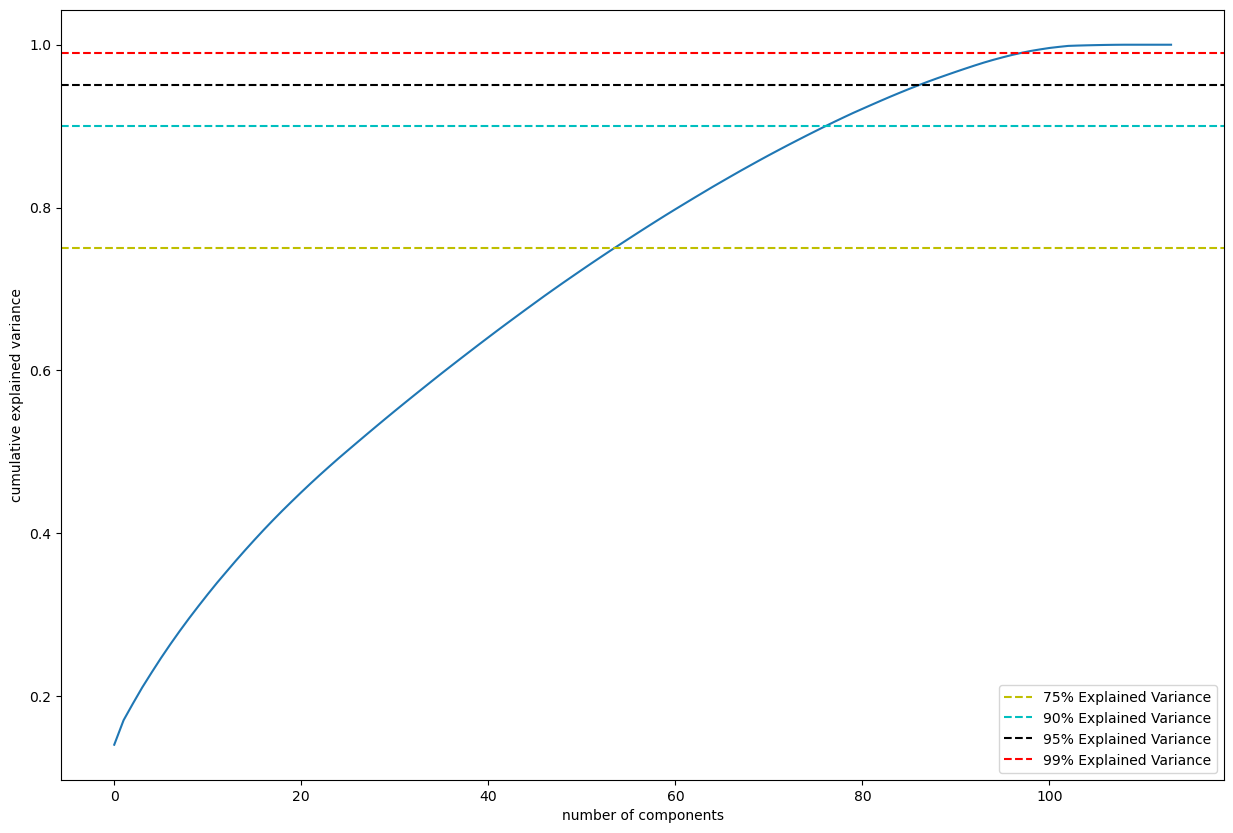

In [464]:
from sklearn.pipeline import Pipeline as Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED))
    ]
)
pipeline.fit(X_train)

### Show the number of the explained variance ratio and the number of components
print(pipeline.named_steps["pca"].explained_variance_ratio_)
print("Number of Components: ", pipeline.named_steps["pca"].n_components_)

### Plot explained variance as a function of number of Components
fig, ax = plt.subplots(1,1, figsize=(15,10), squeeze=False)
ax = plt.plot(np.cumsum(pipeline.named_steps["pca"].explained_variance_ratio_))
### Draw horizontal lines at 0.75, 0.9, 0.95, 0.99
plt.axhline(y = 0.75, color='y', linestyle='--', label = '75% Explained Variance')
plt.axhline(y = 0.90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 0.95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 0.99, color='r', linestyle='--', label = '99% Explained Variance')

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(loc='best')
plt.show()

In [465]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [466]:
pca_var_lst = [0.75, 0.90, 0.95, 0.99]
n_comp_lst = []
for i in pca_var_lst:
    pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(i, random_state=RANDOM_SEED))
    ])
    pipeline.fit(X_train)
    n_comp = pipeline.named_steps["pca"].n_components_
    n_comp_lst.append(n_comp)
    print(f"{i*100} % explained variance: {n_comp}")
print(n_comp_lst)

75.0 % explained variance: 55
90.0 % explained variance: 78
95.0 % explained variance: 87
99.0 % explained variance: 98
[55, 78, 87, 98]


In [467]:
pca_rf_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("rforest", RandomForestClassifier(random_state=RANDOM_SEED))
    ]
)

pca_rf_estimator = GridSearchCV(
    estimator=pca_rf_pipeline,
    param_grid = {
        "pca__n_components":[55, 78, 87, 98],
        "rforest__max_depth":[ 20, 30, 50, 70,  90],
        "rforest__n_estimators":[50, 100,150,200],
        # "rforest__bootstrap":[True, False],
        # # "rforest__criterion":["gini", "entropy", "log_loss"]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

pca_rf_estimator.fit(X_train, y_train)
print(f"The best parameters: {pca_rf_estimator.best_params_}")

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=50; total time=   4.5s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=50; total time=   4.2s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=50; total time=   4.3s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=100; total time=   8.2s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=100; total time=   8.5s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=100; total time=   8.3s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=150; total time=  12.0s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=150; total time=  11.9s
[CV] END pca__n_components=55, rforest__max_depth=20, rforest__n_estimators=150; total time=  12.2s
[CV] END pca__n_components=55, rforest__m

In [468]:
### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
pca_rf_pipeline.set_params(**pca_rf_estimator.best_params_)
pca_rf_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
pca_rf_pred = pca_rf_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, pca_rf_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, pca_rf_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, pca_rf_pred):.4f}")

Classification Report:
                          precision    recall  f1-score   support

             Accounting       0.07      0.13      0.09        87
            Advertising       0.01      0.01      0.01        96
            Agriculture       0.04      0.04      0.04       101
           Architecture       0.12      0.12      0.12        90
                   Arts       0.03      0.02      0.02       110
             Automotive       0.06      0.07      0.06       106
                Banking       0.07      0.09      0.08        91
                Biotech       0.07      0.08      0.08        96
       BusinessServices       0.05      0.05      0.05        96
              Chemicals       0.07      0.14      0.10        87
   Communications-Media       0.01      0.01      0.01       108
           Construction       0.05      0.04      0.04       110
             Consulting       0.05      0.05      0.05       104
              Education       0.04      0.02      0.03       111


# ohne PCA


In [ ]:
rf_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("rforest", RandomForestClassifier(random_state=RANDOM_SEED))
    ]
)

rf_estimator = GridSearchCV(
    estimator=rf_pipeline,
    param_grid = {
        "rforest__max_depth":[ 20, 30, 50, 70,  90],
        "rforest__n_estimators":[50, 100,150,200],
        # "rforest__bootstrap":[True, False],
        # # "rforest__criterion":["gini", "entropy", "log_loss"]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

rf_estimator.fit(X_train, y_train)
print(f"The best parameters: {rf_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
rf_pipeline.set_params(**rf_estimator.best_params_)
rf_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
rf_pred = rf_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, rf_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, rf_pred):.4f}")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
lr_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("lr", LogisticRegression(max_iter=10000))
    ]
)

lr_estimator = GridSearchCV(
    estimator=lr_pipeline,
    param_grid = {
        "pca__n_components":[21, 29, 32, 35],
        "lr__penalty": ["l1", "l2", "elasticnet", None]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

lr_estimator.fit(X_train, y_train)
print(f"The best parameters: {lr_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
lr_pipeline.set_params(**lr_estimator.best_params_)
lr_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
lr_pred = lr_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, lr_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, lr_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, lr_pred):.4f}")

In [ ]:
kNN_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(random_state=RANDOM_SEED)),
        ("kNN", KNeighborsClassifier())
    ]
)

kNN_estimator = GridSearchCV(
    estimator=kNN_pipeline,
    param_grid = {
        "pca__n_components":[21, 29, 32, 35],
        "kNN__n_neighbors": [3, 5,8, 10,13,15,17, 20,22,25,28,30,32,35,37,40,42,45,47 50]
    },
    cv=3,
    verbose=2,
    scoring="f1_weighted",
    )

kNN_estimator.fit(X_train, y_train)
print(f"The best parameters: {kNN_estimator.best_params_}")

### Setze die besten Parameter in die Pipeline ein und fitte erneut auf Trainingsdaten
kNN_pipeline.set_params(**kNN_estimator.best_params_)
kNN_pipeline.fit(X_train, y_train)

### Klassifierungsevaluation
kNN_pred = kNN_pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, kNN_pred))
print("TESTING RESULTS: \n===============================")
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, kNN_pred)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, kNN_pred):.4f}")

# NS


In [ ]:
X_train.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_28,Topic_29,Topic_30,Topic_31,Topic_32,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37
18319,0.000,0.000,0.012,0.000,0.000,0.000,0.000,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.12
8086,0.518,0.123,0.274,0.137,0.015,0.024,0.216,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.025,0.0,0.006,0.0,0.0,0.00
447,0.000,0.000,0.042,0.000,0.000,0.008,0.000,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.020,0.0,0.0,0.00
12545,0.012,0.027,0.147,0.000,0.000,0.000,0.000,0.0,0.0,0.0,...,0.111,0.0,0.0,0.695,0.000,0.0,0.000,0.0,0.0,0.00
7176,0.176,0.000,0.005,0.000,0.000,0.000,0.000,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0,0.00


--> mit to nesor den vektor umwandln udnd amit übergeben, müsste klappen --> basierend ddavorn mit pytorch oder tf das einfach machen

In [437]:
X_NS=overview['perc_list']
y_NS=overview['topic']
X_train_NS, X_test_NS, y_train_NS, y_test_NS = train_test_split( X_NS, y_NS, test_size=0.20, random_state=RANDOM_SEED)

In [438]:
X_NS[0:5]

0    [0.0, 0.0, 0.16700000000000004, 0.0, 0.021, 0....
1    [0.176, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
2    [1.863999999999999, 0.05, 0.5950000000000003, ...
3    [0.0, 0.0, 0.08300000000000002, 0.08, 0.0, 0.0...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: perc_list, dtype: object

In [440]:
df_overview=overview.merge(overview_nomen[['perc_list']], left_index=True, right_index=True).merge(overview_gesamt[['perc_list']], left_index=True, right_index=True).head()

In [443]:
df_overview=overview.merge(overview_nomen[['perc_list']], left_index=True, right_index=True).merge(overview_gesamt[['perc_list']], left_index=True, right_index=True).head()
df_overview=df_overview.rename(columns={"perc_list_x": "list_alle", "perc_list_y": "list_normen", "perc_list": "list_gesamt"})

In [469]:
df_overview.to_csv('over.csv')

In [446]:
pd.DataFrame(data=df_overview['list_alle'].tolist(),columns=[f'Topic_{x}' for x in range(len(df_overview['list_alle'][0]))]).merge(
    pd.DataFrame(data=df_overview['list_normen'].tolist(),columns=[f'Topic_{x+num_topics}' for x in range(len(df_overview['list_normen'][0]))])
    , left_index=True, right_index=True).merge(
    pd.DataFrame(data=df_overview['list_gesamt'].tolist(),columns=[f'Topic_{x+num_topics*2}' for x in range(len(df_overview['list_gesamt'][0]))])
    , left_index=True, right_index=True).merge(
    df_overview['topic']
    , left_index=True, right_index=True)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_105,Topic_106,Topic_107,Topic_108,Topic_109,Topic_110,Topic_111,Topic_112,Topic_113,topic
0,0.000,0.00,0.167,0.00,0.021,0.000,0.000,0.403,0.0,0.022,...,0.000,0.0,0.012,0.0,0.0,0.000,0.006,0.000,0.000,Student
1,0.176,0.00,0.083,0.00,0.000,0.000,0.000,0.000,0.0,0.000,...,0.007,0.0,0.000,0.0,0.0,0.002,0.000,0.000,0.000,Student
2,1.864,0.05,0.595,0.00,0.000,0.189,0.216,0.000,0.0,0.000,...,0.005,0.0,0.014,0.0,0.0,0.019,0.010,0.012,0.002,Student
3,0.000,0.00,0.083,0.08,0.000,0.056,0.000,0.417,0.0,0.000,...,0.003,0.0,0.011,0.0,0.0,0.002,0.004,0.000,0.000,Student
4,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0.000,...,0.000,0.0,0.003,0.0,0.0,0.000,0.000,0.000,0.000,Student
